1. Import thư viện và cấu hình môi trường

In [15]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from model import NaiveBayesFromScratch

2. Tiền xử lý dữ liệu

In [9]:
# Đọc dữ liệu và xử lý lỗi định dạng dấu phẩy thừa
df = pd.read_csv("data/spam.csv", encoding="latin-1")
df = df.loc[:, ~df.columns.str.contains("Unnamed")]
df.columns = ["Label", "Message"]
df["Message_raw"] = df["Message"] 

# Hàm làm sạch nội dung tin nhắn
def clean_text(text):
    text = text.lower() 
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip() 
    return text

# Áp dụng làm sạch và mã hóa nhãn (ham: 0, spam: 1)
df["Message"] = df["Message"].apply(clean_text)
df["Label"] = df["Label"].map({"ham": 0, "spam": 1})

# Lưu dữ liệu đã làm sạch 
df[["Label", "Message"]].to_csv("data/spam_cleaned.csv", index=False)

# Kiểm thử
df.head()

,Label,Message,Message_raw
0,0,go until jurong point crazy available only in ...,"Go until jurong point, crazy.. Available only ..."
1,0,ok lar joking wif u oni,Ok lar... Joking wif u oni...
2,1,free entry in a wkly comp to win fa cup final ...,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,u dun say so early hor u c already then say,U dun say so early hor... U c already then say...
4,0,nah i dont think he goes to usf he lives aroun...,"Nah I don't think he goes to usf, he lives aro..."


3. Trích xuất đặc trưng

In [10]:
# Chia tập Train (80%) và tập Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df["Message"], df["Label"], 
    test_size=0.2, random_state=42
)

# Vector hóa dữ liệu bằng TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

4. Huấn luyện mô hình

In [11]:
# Huấn luyện mô hình Naive Bayes viết tay
model = NaiveBayesFromScratch()
model.fit(X_train_tfidf, y_train)

5. Đánh giá và trực quan hóa

Accuracy: 0.9730941704035875

Classification Report:
               precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       965
        Spam       1.00      0.80      0.89       150

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



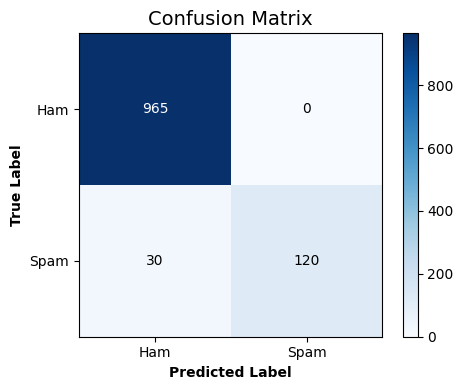

In [12]:
# Dự đoán và in kết quả
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))

# Trực quan hóa Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix", fontsize=14)
plt.colorbar(im)

plt.xticks([0, 1], ["Ham", "Spam"])
plt.yticks([0, 1], ["Ham", "Spam"])
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')

# Thêm số lượng mẫu vào các ô
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

6. So sánh kết quả

In [13]:
# So sánh với mô hình MultinomialNB của Sklearn
from sklearn.naive_bayes import MultinomialNB
sk_model = MultinomialNB()
sk_model.fit(X_train_tfidf, y_train)
print("Sklearn Accuracy Baseline:", accuracy_score(y_test, sk_model.predict(X_test_tfidf)))

# Lưu kết quả dự đoán chi tiết 
results = pd.DataFrame({
    "Message": X_test,
    "True Label": y_test,
    "Predicted Label": y_pred
})
results.to_csv("predictions.csv", index=False)

Sklearn Accuracy Baseline: 0.9730941704035875


7. Thử nghiệm mở rộng

In [14]:
results_comparison = []

# Cấu hình thử nghiệm
configs = [
    ("Unigram (1,1)", (1, 1), 3000),
    ("Bigram (1,2)", (1, 2), 5000)
]

for name, ngram, features in configs:
    # Trích xuất đặc trưng
    vec = TfidfVectorizer(stop_words="english", max_features=features, ngram_range=ngram)
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    
    # Huấn luyện model 
    nb_model = NaiveBayesFromScratch()
    nb_model.fit(X_train_vec, y_train)
    
    # Đánh giá
    y_pred_vec = nb_model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred_vec)
    report = classification_report(y_test, y_pred_vec, output_dict=True)
    
    results_comparison.append({
        "Config": name,
        "Accuracy": acc,
        "Spam Recall": report["1"]["recall"], 
        "Features": X_train_vec.shape[1]
    })

# Hiển thị kết quả 
df_res = pd.DataFrame(results_comparison)
print(df_res)

          Config  Accuracy  Spam Recall  Features
0  Unigram (1,1)  0.973094     0.800000      3000
1   Bigram (1,2)  0.969507     0.773333      5000
